# Assignment — GNN and Knowledge graphs

In [ ]:
import torch.nn.functional as F
from zlib import adler32
from tqdm.notebook import tqdm, trange
import numpy as np
from sklearn.metrics import balanced_accuracy_score
import pandas as pd
import requests
from tqdm.notebook import trange
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
import torch

### CORA dataset

In [ ]:
!pip install  dgl -f https://data.dgl.ai/wheels/torch-2.4/repo.html

Looking in links: https://data.dgl.ai/wheels/torch-2.4/repo.html


In [ ]:
import dgl
from dgl.data import CoraGraphDataset
from dgl import function as fn
from dgl.nn import SAGEConv

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 10556/2 links. Let us take a closer look at this dataset. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

In [ ]:
data = CoraGraphDataset(force_reload=True)

/root/.dgl/cora_v2.zip:   0%|          | 0.00/132k [00:00<?, ?B/s]

Extracting file to /root/.dgl/cora_v2_d697a464
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


In [ ]:
graph = data[0]
graph

Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'label': Scheme(shape=(), dtype=torch.int64), 'feat': Scheme(shape=(1433,), dtype=torch.float32)}
      edata_schemes={})

Adjacency matrix can be obtained as follows

In [ ]:
adj = graph.adj().to_dense()
adj

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

Feature matrix is stored in node features `feat`.

In [ ]:
feat = graph.ndata['feat']
print(feat.shape)
feat

torch.Size([2708, 1433])


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In DGL, Cora feature matrix are normalized so that the sum per row is 1. Labels are represent type of the publication, they are stored in `label`.

In [ ]:
label = graph.ndata['label']
label

tensor([3, 4, 4,  ..., 3, 3, 3])

Here are train, validation and test masks.

In [ ]:
train_mask = graph.ndata['train_mask']
val_mask = graph.ndata['val_mask']
test_mask = graph.ndata['test_mask']
val_mask, train_mask, test_mask

(tensor([False, False, False,  ..., False, False, False]),
 tensor([ True,  True,  True,  ..., False, False, False]),
 tensor([False, False, False,  ...,  True,  True,  True]))

### Task 1. Graph convolution as matrix product (0 points)

Graph convolutional network (GCN) was proposed in [[1]](#references) and defined on an undirected graph as the following propagation rule:

$$H^{(l)}=\sigma\left(\tilde D^{-1 / 2} \tilde A \tilde D^{-1 / 2} H^{(l-1)} W^{(l)}\right)$$

where $\tilde A = A + I_N$ is the adjacency matrix with added self-connections. $I_N$ is the identity matrix, $\tilde D_{ii} = \sum_j \tilde A_{ij}$ is the degree matrix and $W^{(l)}$ is trainable matrix at the layer $l$. $\sigma$ represents non-linear activation function such as ReLU. $H^{(l)}$ is the hidden states at the layer $l$ and $H^{(0)} = X$ is the initial feature matrix.

Write a class `GCNMatrixProductLayer` that takes adjacency matrix, hidden states and returns the next hidden states before activation.

In [ ]:
class GCNMatrixProductLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.dense = nn.Linear(in_dim, out_dim)

    def forward(self, adj, h):
        _adj = adj.clone()
        # YOUR CODE HERE
        #raise NotImplementedError()
        _adj = _adj + np.eye(_adj.shape[0], dtype='float32')
        _d = _adj.sum(dim=0) ** (-0.5)

        _adj = _d[:, None] * _adj * _d[None, :]
        h = _adj @ self.dense(h)
        return h



In [ ]:
layer = GCNMatrixProductLayer(in_dim=2708, out_dim=10)
with torch.no_grad():
    layer.dense.weight.fill_(0.1)
    layer.dense.bias.fill_(0.1)
    h = layer(adj, torch.eye(2708))
assert round(h[0, 0].item(), 2) == 0.19

Write a class `GCNMatrixProduct` that takes the adjacency matrix and feature matrix and performs two-layer convolution with intermediate ReLU activation. The class initialized by input, hidden and output dimensions.

In [ ]:
class GCNMatrixProduct(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        # YOUR CODE HERE
        #raise NotImplementedError()
        self.conv1 = GCNMatrixProductLayer(in_dim,  hid_dim)
        self.conv2 = GCNMatrixProductLayer(hid_dim, out_dim)

    def forward(self, adj, feat):
        # YOUR CODE HERE
        #raise NotImplementedError()
        h = F.relu(self.conv1(adj, feat))
        h = self.conv2(adj, h)
        return h

In [ ]:
model = GCNMatrixProduct(2708, 32, 7)
logits = model(adj, torch.eye(2708))
assert logits.shape == (2708, 7)
assert logits.min() < 0

Let us create the two-layer GCN for node classification task.

In [ ]:
model = GCNMatrixProduct(1433, 32, 7)
opt = torch.optim.Adam(model.parameters(), lr=0.01)
log = []

We train the model in semi-supervised setting: propagate information over the full graph, but optimize it by only train cross-entropy loss.

  0%|          | 0/200 [00:00<?, ?it/s]

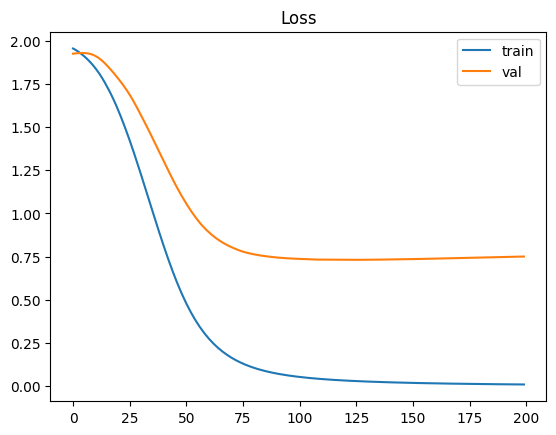

In [ ]:
n_epochs = 200
for i in trange(n_epochs):

    logits = model(adj, feat)
    train_loss = F.cross_entropy(logits[train_mask], label[train_mask])

    opt.zero_grad()
    train_loss.backward()
    opt.step()

    with torch.no_grad():
        val_loss = F.cross_entropy(logits[val_mask], label[val_mask])

    log.append([train_loss.item(), val_loss.item()])

plt.plot(np.array(log))
plt.title('Loss')
plt.legend(['train', 'val'])
plt.show()

We evaluate the model by balanced accuracy that accounts for inbalanced classes.

In [ ]:
with torch.no_grad():
    logits = model(adj, feat)
y_pred = torch.argmax(logits[test_mask], 1)
score = balanced_accuracy_score(label[test_mask], y_pred)
assert score > 0.7
print(f'Balanced accuracy: {score:.2f}')

Balanced accuracy: 0.81


### Task 2. Graph convolution as message passing (0 points)

The original GCN is computationally expensive for large graphs since it requires to compute matrix product $\tilde D^{-1 / 2} \tilde A \tilde D^{-1 / 2} H^{l}$, that costs $O(|V|^2)$. However, the information is propagated along edges, the number of which is linearly depends on the number of nodes in scale-free networks, that is $O(|V|)$. Message passing framework was proposed in [[2]](#references) to reduce computation costs by representing a graph neural network's layer as the composition of two functions:

$$m_{ij}^l = \text{Message}\left(h_i^{l-1}, h_j^{l-1}\right)$$
$$h_i^l = \text{Reduce}_{j \in \mathcal{N}_\text{in}(i)}\left(m_{ji}^l\right)$$

where $\text{Message}(\cdot)$ is the message function that applied on each edges in the graph and stores computed values (messages) on edges. $\text{Reduce}_{j \in \mathcal{N}_\text{in}(i)}(\cdot)$ is the reduce (aka aggregation, reduction) function that applied on each node and aggregates messages from incoming links (mailboxes).

<img src='https://raw.githubusercontent.com/netspractice/network-science/main/images/messpass.png' width=600>

In particular, GCN can be represented as follows:

$$h_i^l = \sigma \left(W^l \sum_{j \in \mathcal{N}_\text{in}(i)}\frac{h_j^{l-1}}{\sqrt{|\mathcal{N}_\text{in}(j)||\mathcal{N}_\text{in}(i)|}}\right)$$

where the message function

$$m_{ji}^l = \frac{W^l h_j^{l-1}}{\sqrt{|\mathcal{N}_\text{in}(j)|}}$$

is the transformed source node's hidden state normalized by the in-degree of the source node. The reduce function

$$h_i^l = \sigma \left(\frac{\sum_{j \in \mathcal{N}_\text{in}(i)} m_{ji}^l}{\sqrt{|\mathcal{N}_\text{in}(i)|}}\right)$$

is the sum over all incoming neighbors' hidden states with in-degree normalization and subsequent activation $\sigma$. Here we assume that the graph includes self-connections, that is a node is in its neighborhood. We also assume that the graph is equivalent to its undirected representation, that is $A = A^\top$.

In DGL, message passing is applied by `graph.update_all(message_func, reduce_func)` where `message_func` is defined on edges and `reduce_func` on nodes. DGL contains built-in message and reduce functions, but it is also possible to define your own functions. GCN can be implemented using following functions:
* message function `fn.copy_u(u='h', out='m')` copies the source node feature `h` into the mailbox `m`
* reduce function `fn.sum(msg='m', out='h')` sums messages from mailboxes `m` and save the result into the node feature `h`

Write a class `GCNMessagePassingLayer` that takes a graph, hidden states and returns the next hidden states before activation.

*Hints:*
* _adding node features is similar to adding values to a dictionary: `graph.ndata['h'] = h`_
* _in-degrees can be computed by `graph.in_degrees()`_

*Remark: `graph.local_scope()` makes all operations isolated from the original graphs.*

In [ ]:
class GCNMessagePassingLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.dense = nn.Linear(in_dim, out_dim)
    def forward(self, graph, h):
        with graph.local_scope():
            graph = graph.add_self_loop()
            # YOUR CODE HERE
            #raise NotImplementedError()
            norm = graph.in_degrees()[:, None] ** (-0.5)

            #Формируем сообщение m
            h = self.dense(h)
            h = h * norm

            graph.ndata['h'] = h

            #Передача сообщений и агрегация
            graph.update_all(fn.copy_u(u='h', out='m'),
                             fn.sum(msg='m', out='h')
                             )

            h = graph.ndata['h']
            h = h * norm

            return h


In [ ]:
layer = GCNMessagePassingLayer(in_dim=2708, out_dim=10)
with torch.no_grad():
    layer.dense.weight.fill_(0.1)
    layer.dense.bias.fill_(0.1)
    h = layer(graph, torch.eye(2708))
assert round(h[0, 0].item(), 2) == 0.19

Write a class `GCNMessagePassing` that takes the graph and feature matrix and performs two-layer convolution with intermediate ReLU activation. The class initialized by input, hidden and output dimensions.

In [ ]:
class GCNMessagePassing(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        # YOUR CODE HERE
        #raise NotImplementedError()
        self.conv1 = GCNMessagePassingLayer(in_dim,  hid_dim)
        self.conv2 = GCNMessagePassingLayer(hid_dim, out_dim)

    def forward(self, graph, feat):
        # YOUR CODE HERE
        #raise NotImplementedError()
        h = F.relu(self.conv1(graph, feat))
        h = self.conv2(graph, h)
        return h

In [ ]:
model = GCNMessagePassing(2708, 32, 7)
logits = model(graph, torch.eye(2708))
assert logits.shape == (2708, 7)
assert logits.min() < 0

In [ ]:
model = GCNMessagePassing(in_dim=1433, hid_dim=32, out_dim=7)
opt = Adam(model.parameters(), lr=0.01)
log = []

We train the model in semi-supervised setting: propagate information over the full graph, but optimize it by only train cross-entropy loss.

  0%|          | 0/200 [00:00<?, ?it/s]

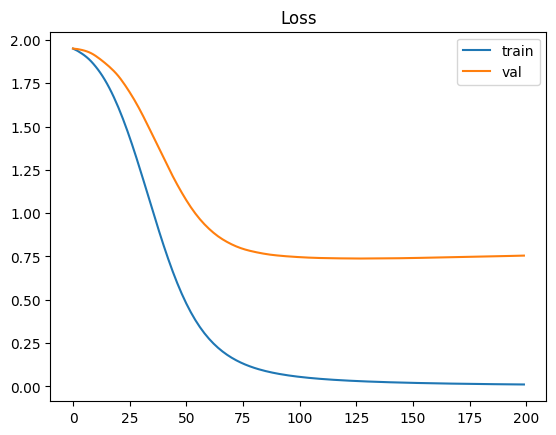

In [ ]:
n_epochs = 200
for i in trange(n_epochs):

    logits = model(graph, feat)
    train_loss = F.cross_entropy(logits[train_mask], label[train_mask])

    opt.zero_grad()
    train_loss.backward()
    opt.step()

    with torch.no_grad():
        val_loss = F.cross_entropy(logits[val_mask], label[val_mask])

    log.append([train_loss.item(), val_loss.item()])

plt.plot(np.array(log))
plt.title('Loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
with torch.no_grad():
    logits = model(graph, feat)
y_pred = torch.argmax(logits[test_mask], 1)
score = balanced_accuracy_score(label[test_mask], y_pred)
assert score > 0.7
print(f'Balanced accuracy: {score:.2f}')

Balanced accuracy: 0.80


### Task 3. Graph auto-encoder (0 points)

Graph auto-encoder (GAE) was proposed in [[3]](#references) as a simple node embedding model that incorporates node features. The model is consists of two parts:
* GCN node encoder $Z = \text{GCN}(X, A)$ where $X$ is the feature matrix
* Dot product decoder $\hat A = \sigma(ZZ^\top)$ where $\sigma$ is the sigmoid function

Write a class `DotProductDecoder` that takes node embeddgins and returns dot product before activation.

In [ ]:
class DotProductDecoder(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, z):
        # YOUR CODE HERE
        #raise NotImplementedError()
        rec_adj = z @ z.T
        return rec_adj

In [ ]:
decoder = DotProductDecoder()
assert torch.all(decoder(torch.eye(2)[:, :1]) * 2 == torch.tensor([[2, 0], [0, 0]]))

The GAE is trained to reconstruct the adjacency matrix, that is the decoder can be considered as the link prediction model. The reconstruction loss is the binary cross entropy between the adjacency matrix $A$ and reconstructed adjacency matrix $\hat A$. To overcome the imbalance between positive and negative edges, the loss is computed with positive weights — the number of negative exaples divided by the number of positive examples, that is $(|V|^2 - E)/E$.

Write a class `ReconstructionLoss` that takes reconstructed adjacency matrix and computes the binary cross entropy with positive weights `F.binary_cross_entropy_with_logits(input, target, pos_weight=...)`. The class is initialized by the adjacency matrix.

In [ ]:
class ReconstructionLoss:
    def __init__(self, adj):
        # YOUR CODE HERE
        #raise NotImplementedError()
        self.adj = adj
        self.pos_weight = (adj.shape[0] ** 2 - adj.sum()) / adj.sum()


    def __call__(self, rec_adj):
        # YOUR CODE HERE
        #raise NotImplementedError()
        return F.binary_cross_entropy_with_logits(rec_adj, self.adj, pos_weight=self.pos_weight)

In [ ]:
rec_loss = ReconstructionLoss(torch.eye(2))
assert round(rec_loss(1 - torch.eye(2)).item(), 4) == 1.0032

Here we initialize encoder, decoder, reconstruction loss and optimizer.

In [ ]:
encoder = GCNMessagePassing(in_dim=1433, hid_dim=64, out_dim=32)
decoder = DotProductDecoder()
rec_loss = ReconstructionLoss(adj)
opt = Adam(encoder.parameters(), lr=0.02)
log = []

Complete the training loop for GAE. Train the model in unsupervised setting: calculate the reconstruction loss over all edges.

  0%|          | 0/400 [00:00<?, ?it/s]

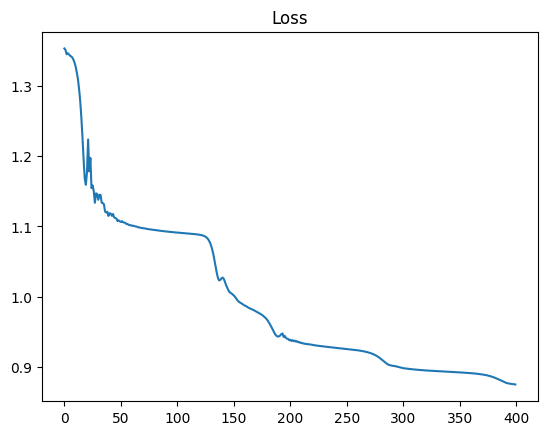

In [ ]:
n_epochs = 400
for i in trange(n_epochs):
    # YOUR CODE HERE
    #raise NotImplementedError()
    Z = encoder(graph, feat)
    rec_adj = decoder(Z)
    loss = rec_loss(rec_adj)

    opt.zero_grad()
    loss.backward()
    opt.step()

    log.append(loss.item())

plt.plot(np.array(log))
plt.title('Loss')
plt.show()

We evaluate GAE by obtaining node embeddings via GCN encoder and training the logistic regression for node classification task.

In [ ]:
with torch.no_grad():
    X = encoder.forward(graph, feat).numpy()
y = label.numpy()

lr = LogisticRegression()
lr.fit(X[train_mask], y[train_mask])

y_true = y[test_mask]
y_pred = lr.predict(X[test_mask])
score = balanced_accuracy_score(y_true, y_pred)
assert score >= 0.6
print(f'Balanced accuracy: {score:.2f}')

Balanced accuracy: 0.69


Let us visualize node embeddings via t-SNE.

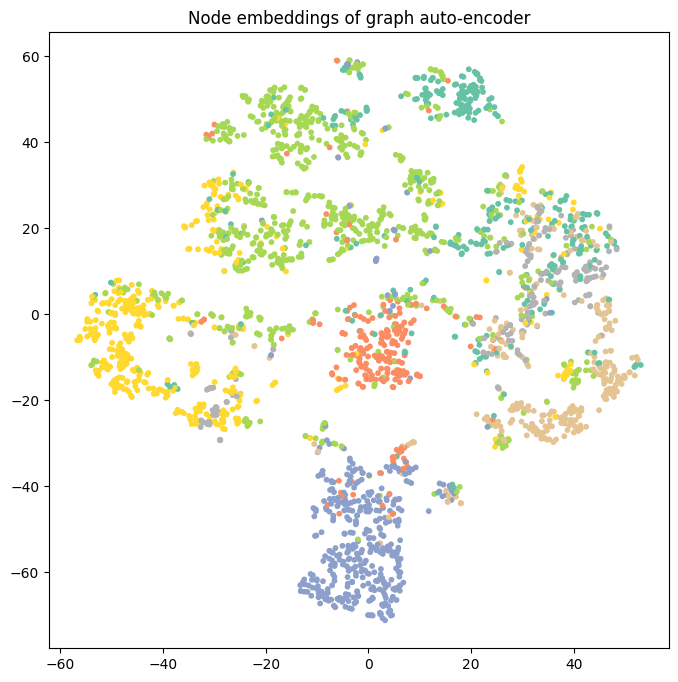

In [ ]:
xy_emb = TSNE(n_components=2).fit_transform(X)
plt.figure(figsize=(8, 8))
plt.title('Node embeddings of graph auto-encoder')
scatter = plt.scatter(xy_emb[:, 0], xy_emb[:, 1], c=label, s=10, cmap=plt.cm.Set2)

Note that GAE is the simplest encoder-decoder graph model that can be extended to the variational graph auto-encoder (VGAE) [[3]](#references) and GraphVAE [[4]](#references).

### Task 4. Graph attention network (4 points)

The graph attention network (GAT) was proposed in [[5]](#references). The idea behind GAT is based on the multi-head self-attention mechanism [[6]](#references). The graph attention layer is defined by message passing as follows:

$$h_i^{l} = \sum_{j \in \mathcal{N}(i)}\alpha_{ij}^{l}W_\text{node}^{l}h_j^{l-1}$$

where $\alpha_{ij}$ is the attention score defined on each edge:

$$\alpha_{ij}^{l} = \text{Softmax}_i(e_{ij}^{l})$$

where $e_{ij}^{l}$ is the edge hidden state obtained by the linear transformation of concatenatenated nodes' hidden states and subsequent LeakyReLU activation:

$$e_{ij}^{l} = \text{LeakyReLU}(W_\text{edge}^l[W_\text{node}^{l}h_i^{l-1}||W_\text{node}^{l}h_j^{l-1}])$$

where $[\cdot||\cdot]$ is concatenation. The multi-head self-attention is defined by different types of attention score (heads) $(\alpha_{ij}^{l})_0, (\alpha_{ij}^{l})_1, ..., (\alpha_{ij}^{l})_N,$. The final node's hidden state is obtained by concatenation all heads' outputs.

Here is the GAT layer that calculates nodes' preliminary hidden states by `self.fc` ($W_\text{node}$) layer and copies them to the node feature `z`, then concatenates them on edges by `edge_cat` function and copies to the edge feature `z`, then calculates attention score by `self.attn_fc` ($W_\text{edge}$) layer and performs message passing. At the end, it concatenates the next hidden states from all heads.

_Remark: `graph.apply_edges` applies an edge-wise function on all edges in the graph._

In [ ]:
class GATLayer(nn.Module):
    def __init__(self, in_dim, out_dim, n_heads):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim)
        self.n_heads = n_heads
        attn_fc = []
        for _ in range(n_heads):
            attn_fc.append(nn.Linear(2 * out_dim, 1))
        self.attn_fc = nn.ModuleList(attn_fc)

    def forward(self, graph, feat):
        with graph.local_scope():
            graph = graph.add_self_loop()
            graph.ndata['z'] = self.fc(feat)
            graph.apply_edges(edge_cat)
            edge_z = graph.edata['z']
            h = []
            for i in range(self.n_heads):
                graph.edata['e'] = F.leaky_relu(self.attn_fc[i](edge_z))
                graph.update_all(message_func, reduce_func)
                h.append(graph.ndata['h'])
            return torch.cat(h, dim=1)

In DGL, we can implement specific functions that can be applied on edges or nodes. Let us define an edge-wise function that concatenates nodes' preliminary hidden states `z` and copies them to the edge feature `z`. It takes a batch of edges `dgl.udf.EdgeBatch` which contains source node features in the attribute `src`, destination node features in the attribute `dst` and edge features in the attribute `data`. For example:
* `edges.src['z']` is the source node feature `z`
* `edges.dst['z']` is the destination node feature `z`
* `edges.data['e']` is the edges feature `e`

Write a function `edge_cat` that takes a batch of edges and returns a dictionary where the key is `z` and the value is concatenated the source node feature `z` and the destination node feature `z`.

In [ ]:
def edge_cat(edges):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
class EdgeBatch:
    def __init__(self):
        self.src = {'z': torch.arange(10).tile(3, 1)}
        self.dst = {'z': torch.arange(10, 20).tile(3, 1)}
        self.data = {'e': torch.arange(20).tile(5, 1)}
edges = EdgeBatch()
res = edge_cat(edges)
assert res['z'].shape == (3, 20)
assert torch.all(res['z'][0] == torch.arange(20))

Next, implement the message function. Message function simply copies the source nodes' feature `z` and edges' feature `e` into mailboxes `z` and `e`.

Write a function `message_func` that takes a batch of edges and returns a dictionary:
* the key is `z`, the value is source nodes' feature `z`
* the key is `e`, the value is edges' feature `e`

In [ ]:
def message_func(edges):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
class EdgeBatch:
    def __init__(self):
        self.src = {'z': torch.arange(10).tile(3, 1)}
        self.dst = {'z': torch.arange(10, 20).tile(3, 1)}
        self.data = {'e': torch.arange(20).tile(5, 1)}
edges = EdgeBatch()
res = message_func(edges)
assert res['z'].shape == (3, 10)
assert torch.all(res['z'][0] == torch.arange(10))
assert res['e'].shape == (5, 20)
assert torch.all(res['e'][0] == torch.arange(20))

The reduce funtion takes a batch of nodes `dgl.udf.NodeBatch` and calculates the next hidden states of nodes by summation of preliminary hidden states `z` weighted by attention score:
$$\alpha_{ij} = \text{Softmax}_i(e_{ij})$$
$$h_i = \sum_{j \in \mathcal{N}(i)}\alpha_{ij}z_j$$

The batch of nodes contains incoming messages in the attribute `mailbox` of the shape (N, D, 1), where N is the number of nodes in the batch, D is the number of messages received per node for this node batch.

Write a function `reduce_func` that takes a batch of nodes with mailboxes `z` and `e` and returns a dictionary where the key is `h`, the value is the next hidden states of nodes.

In [ ]:
def reduce_func(nodes):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
class NodeBatch:
    def __init__(self):
        self.mailbox = dict()
        self.mailbox['e'] = torch.arange(10, 20, dtype=float).tile(3, 1)[..., None]
        self.mailbox['z'] = torch.arange(10, dtype=float).tile(3, 1)[..., None]
nodes = NodeBatch()
assert reduce_func(nodes)['h'].shape == (3, 1)
assert round(reduce_func(nodes)['h'][0].item(), 4) == 8.4185

Write a class `GAT` that takes a graph and a feature matrix and performs two-layer convolution with intermediate ReLU activation. The class initialized by input, hidden, output dimensions and the number of heads in the first layer. The second layer contains a single head.

In [ ]:
class GAT(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, n_heads):
        super().__init__()
        # self.conv1 = ...
        # self.conv2 = ...
        # YOUR CODE HERE
        raise NotImplementedError()
    def forward(self, graph, feat):
        # YOUR CODE HERE
        raise NotImplementedError()

In [ ]:
model = GAT(2708, 32, 7, n_heads=4)
logits = model.conv1(graph, torch.eye(2708))
assert logits.shape == (2708, 128)
logits = model(graph, torch.eye(2708))
assert logits.shape == (2708, 7)
assert logits.min() < 0

Let us initialize the model and the optimizer.

In [ ]:
model = GAT(in_dim=1433, hid_dim=16, out_dim=7, n_heads=3)
opt = Adam(model.parameters(), lr=0.005, weight_decay=0.001)
log = []

We train the model in semi-supervised setting: propagate information over the full graph, but optimize it by only train cross-entropy loss.

In [ ]:
n_epochs = 120
for i in trange(n_epochs):

    logits = model(graph, feat)
    train_loss = F.cross_entropy(logits[train_mask], label[train_mask])

    opt.zero_grad()
    train_loss.backward()
    opt.step()

    with torch.no_grad():
        val_loss = F.cross_entropy(logits[val_mask], label[val_mask])

    log.append([train_loss.item(), val_loss.item()])

plt.plot(np.array(log))
plt.title('Loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
with torch.no_grad():
    logits = model(graph, feat)
y_pred = torch.argmax(logits[test_mask], 1)
score = balanced_accuracy_score(label[test_mask], y_pred)
assert score > 0.7
print(f'Balanced accuracy: {score:.2f}')

We can explain model's predictions using GAT — neighbors with large attention score have the great impact to model's prediction. Let us calculate the neighbors importance using the attention score.

Write a function `neighbor_importance` that takes a node index for which we want to explain the prediction, a trained GAT, a graph and a feature matrix. It returns a tuple:
* np.array with indices of neighbors
* np.array with attention scores on the first GAT layer for each neighbor. Attention score is averaged among all heads.

_Hint: use `graph.predecessors` to obtain neighbors_

In [ ]:
def neighbor_importance(expl_node, model, graph, feat):
    with torch.no_grad(), graph.local_scope():
        graph = graph.add_self_loop()
        # YOUR CODE HERE
        raise NotImplementedError()

        u = ... #predessecors
        v = ... #array for current node
        z = ... #after layer
        ##
        for #head in heads:
          atten = ...
        return ...

In [ ]:
neigh, attn = neighbor_importance(1941, model, graph, feat)
assert type(neigh) == type(attn) == np.ndarray
assert neigh.shape == attn.shape == (6, )
assert round(attn.sum(), 2) == 1
plt.bar(neigh.astype('str'), attn)
plt.xlabel('Node')
plt.ylabel('Attention')
plt.title('Neighbor importance')
plt.show()

### Task 5. Freebase dataset (0 points)

In this assignment we will see how to use the [TorchKGE](https://github.com/torchkge-team/torchkge) library for building knowledge graphs and its embeddings. To begin with we are going to need a knowledge graph, so let us load a standard knowledge graph dataset called _Freebase-15k-237_.

In [ ]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/netspractice/network-science/main/datasets/freebase-237-merged-and-remapped.csv.gz",
    names=['h', 'r', 't'])

In [ ]:
df = df[~df.h.str.startswith('/') & ~df.t.str.startswith('/')]
df[::1000].head(10)

,h,r,t
0,"queens college, city university of new york",/education/educational_institution/students_gr...,carol leifer
1103,sharon stone,/award/award_nominee/award_nominations./award/...,jacob vargas
2210,japan,/location/country/capital,tokyo
3329,syphilis,/medicine/disease/risk_factors,male
4447,michael carlisle hall,/award/award_nominee/award_nominations./award/...,mena suvari
5555,alice in wonderland,/film/film/language,english language
6653,nauru,/location/country/official_language,english language
7743,ben harper,/people/person/spouse_s./people/marriage/type_...,marriage
8840,the perks of being a wallflower,/film/film/country,united states of america
9960,vice president,/business/job_title/people_with_this_title./bu...,scripps howard broadcasting


There is h — head (also subject), r — relation (also predicat, label), t — tail (also object). The shape of the dataset is

In [ ]:
df.shape

(282560, 3)

Let us check the number of unique entities and unique relations.

Write a funtion `n_ent_rel` that takes a dataset and returns a number of unique entities and unique relations.


In [ ]:
def n_ent_rel(df):
    # YOUR CODE HERE
    #raise NotImplementedError()
    X = df.values
    n_rel = np.unique(X[:, 1]).shape[0]

    n_ent = np.unique(np.concatenate([X[:, 0], X[:, 2]])).shape[0]
    return n_ent, n_rel

In [ ]:
n_ent, n_rel = n_ent_rel(df)
assert adler32(str(n_ent + n_ent).encode()) == 50266365
n_ent, n_rel

(13506, 228)

We can look at all facts about any entity via pandas API

In [ ]:
df[df.h ==  'aleksandr pushkin'].head()

,h,r,t
4107,aleksandr pushkin,/people/person/profession,poet
14992,aleksandr pushkin,/influence/influence_node/influenced_by,johann wolfgang von goethe
19525,aleksandr pushkin,/people/person/nationality,russian empire
40237,aleksandr pushkin,/people/person/place_of_birth,moscow
47411,aleksandr pushkin,/influence/influence_node/influenced_by,william shakespeare


In [ ]:
df[(df.h ==  'aleksandr pushkin') & (df.t == 'nikolai gogol')]

,h,r,t
145219,aleksandr pushkin,/influence/influence_node/peers./influence/pee...,nikolai gogol


In [ ]:
df[(df.h ==  'nikolai gogol') & (df.t == 'aleksandr pushkin')]

,h,r,t
86362,nikolai gogol,/influence/influence_node/peers./influence/pee...,aleksandr pushkin
269512,nikolai gogol,/influence/influence_node/influenced_by,aleksandr pushkin


Let us try to find some facts in this dataset. For example, what is Harrison Ford's nationality? ("harrison ford" in the dataset)

Write a function `harrison_ford_nationality` that takes a dataset and returns the nationality.

_Hint: use `pandas.Series.str.contains` method_

In [ ]:
def harrison_ford_nationality(df):
    # YOUR CODE HERE
    #raise NotImplementedError()
    return df[(df.h == 'harrison ford') & (df.r.str.contains('nationality'))].t.iloc[0]

In [ ]:
assert adler32(harrison_ford_nationality(df).encode()) == 1948191013
harrison_ford_nationality(df)

'united states of america'

More tricky question: who are film directors of movies where Harrison Ford was?

Write a function `made_films_with_harrison_ford` that returns a set of directors' names.

In [ ]:
def made_films_with_harrison_ford(df):
    # YOUR CODE HERE
    #raise NotImplementedError()
    films = df[(df.h == 'harrison ford') & (df.r.str.contains('actor'))].t.tolist()
    director = df[df.t.isin(films) & (df.r.str.contains('director'))].h
    return set(director)

In [ ]:
directors = made_films_with_harrison_ford(df)
assert adler32(str(sorted(directors)).encode()) == 3798415057
directors

{'francis ford coppola',
 'george lucas',
 'jon favreau filmography',
 'kathryn bigelow',
 'mike nichols',
 'ridley scott',
 'robert zemeckis',
 'steven spielberg'}

### Task 6. Translation models (0 points)

TransE (translations in the embedding space) is a method which models relationships by interpreting them as translations operating on the low-dimensional embeddings of the entities.

Let us implement the model using TorchKGE — a Python module for knowledge graph embedding relying solely on Pytorch.

In [ ]:
!pip install torchkge==0.16.25 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 3.4 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torchkge import KnowledgeGraph
from torchkge.utils import Trainer
from torchkge.evaluation import LinkPredictionEvaluator
from torchkge.models.interfaces import TranslationModel
from torch.nn.init import xavier_uniform_

<img src='https://github.com/netspractice/ml-on-graphs/raw/main/assignment_knowledge_graph_embedding/kge.png' width=300>

The basic idea behind the model is that the functional relation induced by the $r$-labeled edges corresponds to a translation of the embeddings, i.e. we want that $h + r \approx t$ when ($h$, $r$, $t$) holds ($t$ should be a nearest neighbor of $h + r$), while $h + r$ should be far away from $t$ otherwise. Thereby, TransE scoring function is negative distance between $h+r$ and $t$

$$f(h, r, t) = -||h + r - t||$$

where $||\cdot||$ is L1 or L2 norm. The goal of the optimization procedure is learning optimal embeddings, such that the scoring function is able to assign high scores to positive statements and low scores to statements unlikely to be true. The most common loss function is Margin Loss that can be represented as

$$L = \text{ReLU}\left(\gamma - f(h, r, t) + f(h', r, t')\right)$$

where $\gamma > 0$ is a "margin" hyperparameter, the triplet $(h, r, t)$ is in a training set (positive) and the $(h', r, t')$ is in a set of *corrupted* (negative) triplets, that are composed of training triplets with either the head or tail replaced by a random entity (but not both at the same time).

We will use TorchKGE TranslationModel as a base for TransE class, here are some auxiliary methods:

* `normalize_parameters` applies `L2` normalization for training stability
* `get_embeddings` returns the tensors representing entities and relations
* `lp_prep_cands` gets entities and relations embeddings for link prediction training process
* `forward` returns scores for positive triplets (`h`, `r`, `t`) and negative triplets (`nh`, `r`, `nt`)

In [ ]:
class BaseTransE(TranslationModel):
    def __init__(self, num_entities, num_relations, dim=100):
        super(BaseTransE, self).__init__(num_entities, num_relations, dissimilarity_type='L2')
        self.num_entities = num_entities
        self.num_relations = num_relations
        self.dim = dim
        self.ent_embeddings = nn.Embedding(num_entities, self.dim)
        self.rel_embeddings = nn.Embedding(num_relations, self.dim)

    def normalize_parameters(self):
        self.ent_embeddings.weight.data = F.normalize(self.ent_embeddings.weight.data, p=2, dim=1)

    def get_embeddings(self):
        self.normalize_parameters()
        return self.ent_embeddings.weight.data, self.rel_embeddings.weight.data

    def lp_prep_cands(self, h_idx, t_idx, r_idx):
        b_size = h_idx.shape[0]

        h_emb = self.ent_embeddings(h_idx)
        t_emb = self.ent_embeddings(t_idx)
        r_emb = self.rel_embeddings(r_idx)

        candidates = self.ent_embeddings.weight.data.view(1, self.num_entities, self.dim)
        candidates = candidates.expand(b_size, self.num_entities, self.dim)

        return h_emb, t_emb, candidates, r_emb

    def forward(self, h, t, nh, nt, r):
        return self.scoring_function(h, t, r), self.scoring_function(nh, nt, r)

Write a function `scoring_function` that takes a tensor `h`, `t`, `r` with triplets of the shape (number of triplets) and returns its L2 scores. For training stability, apply L2 normalization (`F.normalize`  with `p=2`) on entities embeddings before computing the scores. Note that `h`, `t`, `r` are tensors with integer IDs of entities and relations.

In [ ]:
class TransE(BaseTransE):
    def scoring_function(self, h, t, r):
        # YOUR CODE HERE
        #raise NotImplementedError()
        h = self.ent_embeddings(h)
        t = self.ent_embeddings(t)
        r = self.rel_embeddings(r)

        h = F.normalize(h, p=2, dim=1)
        t = F.normalize(t, p=2, dim=1)

        score = -torch.norm((h + r - t), p=2, dim=1)
        return score



In [ ]:
model = TransE(num_entities=5, num_relations=2, dim=2)

h = torch.LongTensor([1, 1, 1])
r = torch.LongTensor([0, 1, 1])
t = torch.LongTensor([2, 2, 3])

with torch.no_grad():
    scores = model.scoring_function(h, t, r).numpy()
assert scores.shape == (3, ) # 3 triplets

Complete the class `MarginLoss` so that computes the losses among scores and returns an average loss. Positive and negative scores are tensors of the shape (number of triplets).

In [ ]:
class MarginLoss(nn.Module):
    def __init__(self, margin):
        super().__init__()
        self.margin = margin
    def forward(self, positive_scores, negative_scores):
        # YOUR CODE HERE
        #raise NotImplementedError()
        return F.relu(self.margin - positive_scores + negative_scores).mean()

In [ ]:
loss_fn = MarginLoss(margin=0.5)
torch.manual_seed(0)
positive_scores = torch.randn(8)
negative_scores = torch.randn(8)
loss = loss_fn(positive_scores, negative_scores)
assert loss.shape == torch.Size([])
assert round(loss.item(), 2) == 0.79

Let us look at the WikiDataSet that presents country-specific subgraphs of Wikidata.

In [ ]:
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/countries_edges.tsv'
open('countries_edges.tsv', 'wb').write(requests.get(url).content)
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/countries_entities.tsv'
open('countries_entities.tsv', 'wb').write(requests.get(url).content)
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/countries_relations.tsv'
open('countries_relations.tsv', 'wb').write(requests.get(url).content);

In [ ]:
edges = pd.read_csv('countries_edges.tsv', sep='	').values
entity_labels = pd.read_csv('countries_entities.tsv', sep='	', index_col=0).label.values
relation_labels = pd.read_csv('countries_relations.tsv', sep='	', index_col=0).label.values

In [ ]:
edges_labeled = np.stack([entity_labels[edges[:, 0]],
                          entity_labels[edges[:, 1]],
                          relation_labels[edges[:, 2]]], axis=1)

df = pd.DataFrame(edges_labeled, columns=['h', 't', 'r'])[['h', 'r', 't']]
df.head()

,h,r,t
0,Belgium,country,Belgium
1,Belgium,diplomatic relation,Luxembourg
2,Belgium,diplomatic relation,Italy
3,Belgium,diplomatic relation,Germany
4,Belgium,diplomatic relation,Liechtenstein


Here are unique relations with the number of triplets

In [ ]:
df.r.groupby(df.r).count()

,r
r,
applies to jurisdiction,1
basic form of government,3
biological process,1
capital,34
capital of,25
contains administrative territorial entity,94
country,1339
country of citizenship,5
country of origin,1


Convert our dataset into a TorchKGE knowledge graph

In [ ]:
kg = KnowledgeGraph(
    pd.DataFrame(edges_labeled, columns=['from', 'to', 'rel']))

Split the dataset into train and test set. What differs from the standard method of randomly sampling N points to make up our test set, is that our data points are two entities linked by some relationship, and we need to take care to ensure that all entities are represented in train and test sets by at least one triple.



In [ ]:
kg_train, kg_test = kg.split_kg()

Create required objects: model, loss, optimizer and trainer.

In [ ]:
model = TransE(kg_train.n_ent, kg_train.n_rel, dim=64)
criterion = MarginLoss(margin=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

trainer = Trainer(
    model, criterion, kg_train, n_epochs=500,
    batch_size=2048, optimizer=optimizer)

During training, positive triplets are selected, negative triplets are generated, margin loss is calculated and then the gradient step is performed.

In [ ]:
trainer.run()

  0%|          | 0/500 [00:00<?, ?epoch/s]

Let us evaluate our model on the link prediction task

In [ ]:
evaluator = LinkPredictionEvaluator(model, kg_test)
evaluator.evaluate(b_size=128)

assert evaluator.hit_at_k(k=10)[0] > 0.3
assert evaluator.mean_rank()[0] < 70
assert evaluator.mrr()[0] > 0.1

Link prediction evaluation:   0%|          | 0/17 [00:00<?, ?batch/s]

In [ ]:
print('Hit@10: {:.4f}'.format(evaluator.hit_at_k(k=10)[0]))
print('Mean Rank: {:.4f}'.format(evaluator.mean_rank()[0]))
print('MRR: {:.4f}'.format(evaluator.mrr()[0]))

Hit@10: 0.3337
Mean Rank: 67.2574
MRR: 0.1400


`Hit@k` indicates how many times in average a true triple was ranked in the top-k.

`Mean Rank` is a mean rank of the true entity when replacing alternatively head and tail in any fact of the dataset.

`MRR` is an average of mean recovery rank for head and tail replacement.

### Task 7. Entity embeddings (0 points)

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import k_means
import matplotlib.pyplot as plt

Similarly to node embedding visualization, we can plot 2D embeddings of entities of knowledge graph.

Write a function `ent_embeddgins` that takes the model, transforms entity embeddings into 2-dimenstional space via SVD, then finds 2 clusters via k-means and finally returns a tuple: np.array with embeddings and 0/1 labels of clusters.

In [ ]:
def ent_embeddgins(model):
    # YOUR CODE HERE
    #raise NotImplementedError()
    ent_emb = model.get_embeddings()[0].numpy()
    transformer = TruncatedSVD(n_components=2)
    transformer.fit(ent_emb)
    xy_emb = transformer.transform(ent_emb)
    _, labels, _ = k_means(xy_emb, n_clusters=2)
    return xy_emb, labels

In [ ]:
ent_emb, labels = ent_embeddgins(model)
assert ent_emb.shape == (1810, 2)
assert labels.shape == (1810,)
n_label1 = (labels == 1).sum()
n_label0 = (labels == 0).sum()
assert 0.14 < min(n_label1, n_label0) / max(n_label1, n_label0) < 0.18

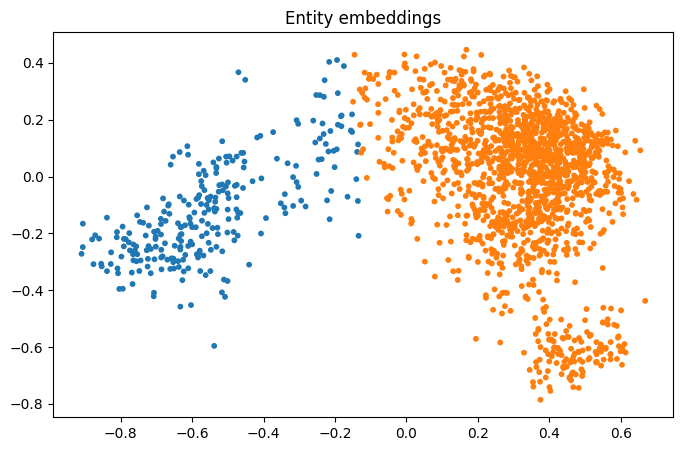

In [ ]:
plt.figure(figsize=(8, 5))
colors = np.array(plt.cm.tab10.colors)
plt.scatter(ent_emb[:, 0], ent_emb[:, 1], s=10, c=colors[labels])
plt.title('Entity embeddings')
plt.show()

Let us look at some randomly chosen entities from each cluster. Here we use `kg.ent2ix` dictionary to get labels of entities.

In [ ]:
ent_labels = np.array(list(kg.ent2ix.keys()))
print('First cluster: ', ', '.join(
    np.random.permutation(ent_labels[labels == 0])[:10]))
print()
print('Second cluster: ', ', '.join(
    np.random.permutation(ent_labels[labels == 1])[:10]))

First cluster:  Oman, Ivory Coast, Romania, Luxembourg, Chile, Madagascar, Slovak State (1939-1945), Mexico, Republic of Abkhazia, Empire of Japan

Second cluster:  Dʿmt, Eighth Dynasty of Egypt, Shaki Khanate, New Netherland, Burgraviate of Nuremberg, principauté impériale du Liechtenstein, Elymais, South-West Africa, Second Saudi State, Mizoram


### Task 8. Nearest neighbors of entities (0 points)

In [ ]:
from sklearn.neighbors import NearestNeighbors

Let us find a nearest neighbors of Belgium using embedding space.

Write a function `similar_countries` that takes a name of country, graph and model and returns a list with names of nearest countries. Use `model.get_embeddings()`.

In [ ]:
def similar_countries(name, kg, model):
    # YOUR CODE HERE
    #raise NotImplementedError()
    idx = kg.ent2ix[name]
    ent_emb = model.get_embeddings()[0].numpy()
    neigh = NearestNeighbors(n_neighbors=5)
    neigh.fit(ent_emb)
    ent2ix = np.array(list(kg.ent2ix.items()))

    similar = []
    for i in neigh.kneighbors([ent_emb[idx]], return_distance=False)[0]:
      similar.append(ent2ix[ent2ix[:, 1] == str(i), 0][0])
    return similar



In [ ]:
similar = similar_countries('Belgium', kg, model)
assert 'Netherlands' in similar
similar

['Belgium',
 'Netherlands',
 'Luxembourg',
 'France',
 'Kingdom of the Netherlands']

### Task 9. Relation prediction (3 points)

Let us consider these facts:
1. Belgium shares border with France
2. Belgium shares border with Switzerland
3. Belgium shares border with Nigeria

Only the fact 1 is truth, but it seems that the fact 2 is more likely than 3.

In [ ]:
df[(df.h == 'Belgium') & (df.t == 'France')]

,h,r,t
8,Belgium,diplomatic relation,France
32,Belgium,shares border with,France


In [ ]:
df[(df.h == 'Belgium') & (df.t == 'Switzerland')]

,h,r,t


In [ ]:
df[(df.h == 'Belgium') & (df.t == 'Nigeria')]

,h,r,t


Now we can compare these facts using scoring function of TransE model to check our prior knowledge.

Write a function `belgium_facts` that takes a model, a graph and returns 3 values of scoring function for each fact. Use `model.scoring_function` with `torch.no_grad()`.

In [ ]:
def belgium_facts(model, kg):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
scores = belgium_facts(model, kg)
assert scores[0] > scores[1] > scores[2]
scores

### Task 10. Tail prediction (3 points)

In [ ]:
from sklearn.neighbors import NearestNeighbors

Recall that the main idea of TransE is to learn $h + r \approx t$, so let us find the closest tails for the head + relation pair.

Write a function `soviet_tail` that takes a model, graph and finds 5 nearest neighbors for the pair $h$ is "Soviet Union" and $r$ is "founded by".

In [ ]:
def soviet_tail(model, kg):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
tails = soviet_tail(model, kg)
assert 'Russian Soviet Federative Socialist Republic' in tails
tails

### References

<a id='references'></a>

[1] Kipf, T. N., & Welling, M. (2016). Semi-Supervised Classification with Graph Convolutional Networks. CoRR, abs/1609.02907. http://arxiv.org/abs/1609.02907

[2] Gilmer, J., Schoenholz, S. S., Riley, P. F., Vinyals, O., & Dahl, G. E. (2017). Neural Message Passing for Quantum Chemistry. CoRR, abs/1704.01212. http://arxiv.org/abs/1704.01212

[3] Kipf, T. N., & Welling, M. (2016). Variational Graph Auto-Encoders. arXiv. https://doi.org/10.48550/ARXIV.1611.07308

[4] Simonovsky, M., & Komodakis, N. (2018). GraphVAE: Towards Generation of Small Graphs Using Variational Autoencoders. CoRR, abs/1802.03480. http://arxiv.org/abs/1802.03480

[5] Veličković, P., Cucurull, G., Casanova, A., Romero, A., Liò, P., & Bengio, Y. (2017). Graph Attention Networks. arXiv. https://doi.org/10.48550/ARXIV.1710.10903

[6] Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, L., & Polosukhin, I. (2017). Attention Is All You Need. CoRR, abs/1706.03762. http://arxiv.org/abs/1706.03762